# Instant Gratification: kernels-only competition

You are provided with a data set with only numeric feature variables, the binary *target* column, and a string *ID_code* column.

The task is to predict the value of target column in the test set.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
import tarfile
import pandas as pd
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from six.moves import urllib
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgbm
from mllib import *

In [3]:
data_train = load_data(data_name="train.csv", data_path='/home/alexandre/ml/kaggle/')
data_test = load_data(data_name="test.csv", data_path='/home/alexandre/ml/kaggle/')

We will start by importing the raw data and making some very basic data visualization:

In [4]:
train = MLDataset(data_frame=data_train)
test = MLDataset(data_frame=data_test)

Data frame dimensions: (262144, 258)


Features available: 

id	
muggy-smalt-axolotl-pembus	
dorky-peach-sheepdog-ordinal	
slimy-seashell-cassowary-goose	
snazzy-harlequin-chicken-distraction	
frumpy-smalt-mau-ordinal	
stealthy-beige-pinscher-golden	
chummy-cream-tarantula-entropy	
hazy-emerald-cuttlefish-unsorted	
nerdy-indigo-wolfhound-sorted	
leaky-amaranth-lizard-sorted	
ugly-tangerine-chihuahua-important	
shaggy-silver-indri-fimbus	
flaky-chocolate-beetle-grandmaster	
squirrely-harlequin-sheep-sumble	
freaky-tan-angelfish-noise	
lousy-plum-penguin-sumble	
bluesy-rose-wallaby-discard	
baggy-copper-oriole-dummy	
stealthy-scarlet-hound-fepid	
greasy-cinnamon-bonobo-contributor	
cranky-cardinal-dogfish-ordinal	
snippy-auburn-vole-learn	
greasy-sepia-coral-dataset	
flabby-tangerine-fowl-entropy	
lousy-smalt-pinscher-dummy	
bluesy-brass-chihuahua-distraction	
goopy-eggplant-indri-entropy	
homey-sepia-bombay-sorted	
homely-ruby-bulldog-entropy	
hasty-blue-sheep-contributor	
blurry-wister

The names are complete nonsense. This is already hinting at a problem similar to the Santander challenge (see *santander.ipynb*). So let's proceed in a similar fashion:

id                                           0
muggy-smalt-axolotl-pembus                   0
dorky-peach-sheepdog-ordinal                 0
slimy-seashell-cassowary-goose               0
snazzy-harlequin-chicken-distraction         0
frumpy-smalt-mau-ordinal                     0
stealthy-beige-pinscher-golden               0
chummy-cream-tarantula-entropy               0
hazy-emerald-cuttlefish-unsorted             0
nerdy-indigo-wolfhound-sorted                0
leaky-amaranth-lizard-sorted                 0
ugly-tangerine-chihuahua-important           0
shaggy-silver-indri-fimbus                   0
flaky-chocolate-beetle-grandmaster           0
squirrely-harlequin-sheep-sumble             0
freaky-tan-angelfish-noise                   0
lousy-plum-penguin-sumble                    0
bluesy-rose-wallaby-discard                  0
baggy-copper-oriole-dummy                    0
stealthy-scarlet-hound-fepid                 0
greasy-cinnamon-bonobo-contributor           0
cranky-cardin

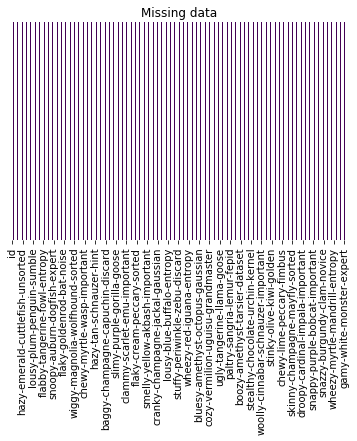

In [5]:
train.check_empty_data()

Let's see if we can get any insight over the variables distributions

In [2]:
train.plot_hist(fig_size=(80,40))

NameError: name 'train' is not defined

Overall, the variables all possess some sort of bell-shaped curve, with no severe skewing. There is, however, one feature that is quite peculiar: 

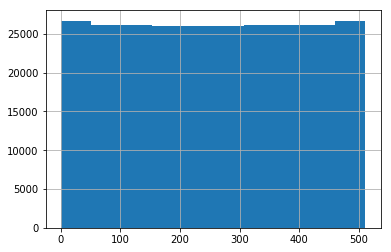

In [6]:
train.df['wheezy-copper-turtle-magic'].hist()

Being nearly flat among bell-shaped curves, it must either hold something interesting, or be completely useless. For the moment, let's deal with the data as is:

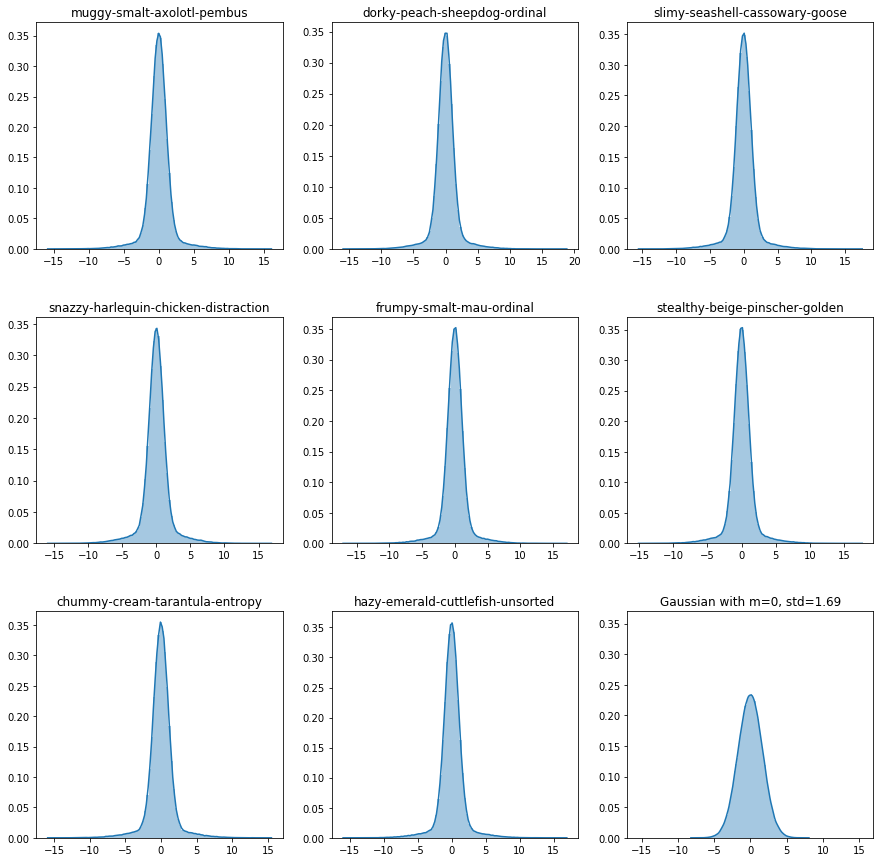

In [7]:
# PLOT FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    sns.distplot(train.df.iloc[:,i+1],bins=100)
    plt.title(train.df.columns[i+1] )
    plt.xlabel('')
    
# PLOT GAUSSIAN FOR COMPARISON
plt.subplot(3,3,9)
std = round(np.std(train.df.iloc[:,8]),2)
data = np.random.normal(0,std,len(train.df))
sns.distplot(data,bins=100)
plt.xlim((-17,17))
plt.ylim((0,0.37))
plt.title("Gaussian with m=0, std="+str(std))

plt.subplots_adjust(hspace=0.3)
plt.show()

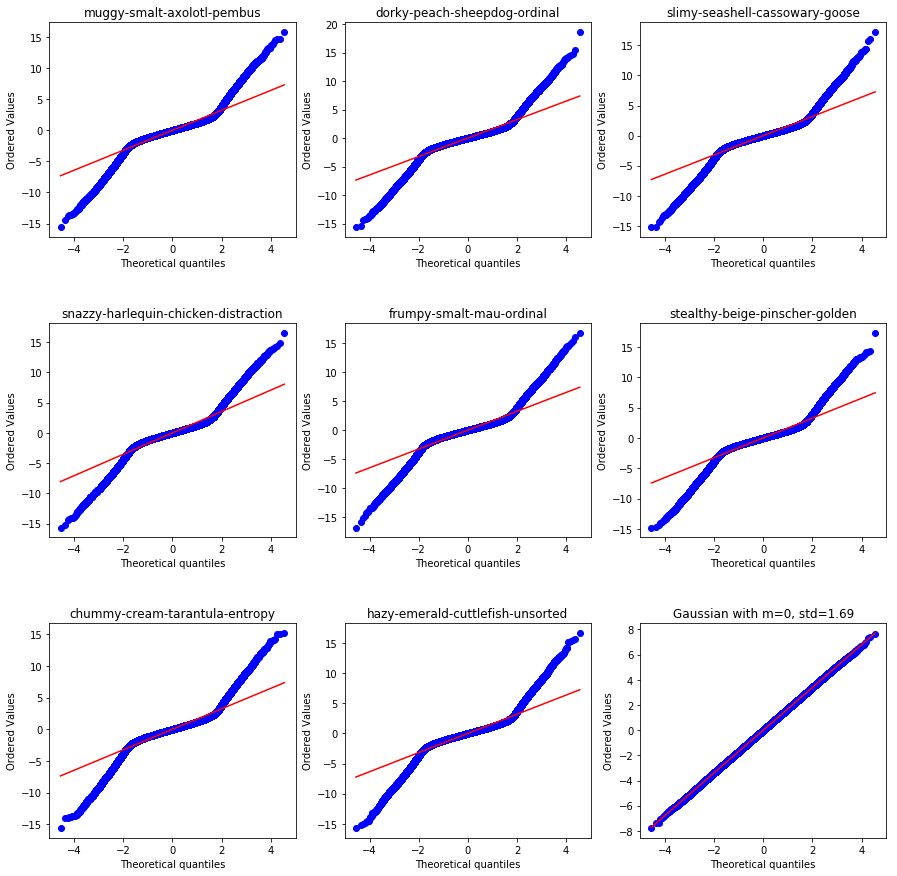

In [8]:
# NORMALITY PLOTS FOR FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    stats.probplot(train.df.iloc[:,i+1], plot=plt)
    plt.title(train.df.columns[i+1] )
    
# NORMALITY PLOT FOR GAUSSIAN
plt.subplot(3,3,9)
stats.probplot(data, plot=plt)   
plt.title("Gaussian with m=0, std="+str(std))

plt.subplots_adjust(hspace=0.4)
plt.show()

So none of these variables we inspected are Gaussian. However, this Kaggle competitor (https://www.kaggle.com/cdeotte/support-vector-machine-0-925) found a very interesting feature: for a fixed value of the uniformly distributed *wheezy-copper-turtle-magic*, the data begins to behave normally: 

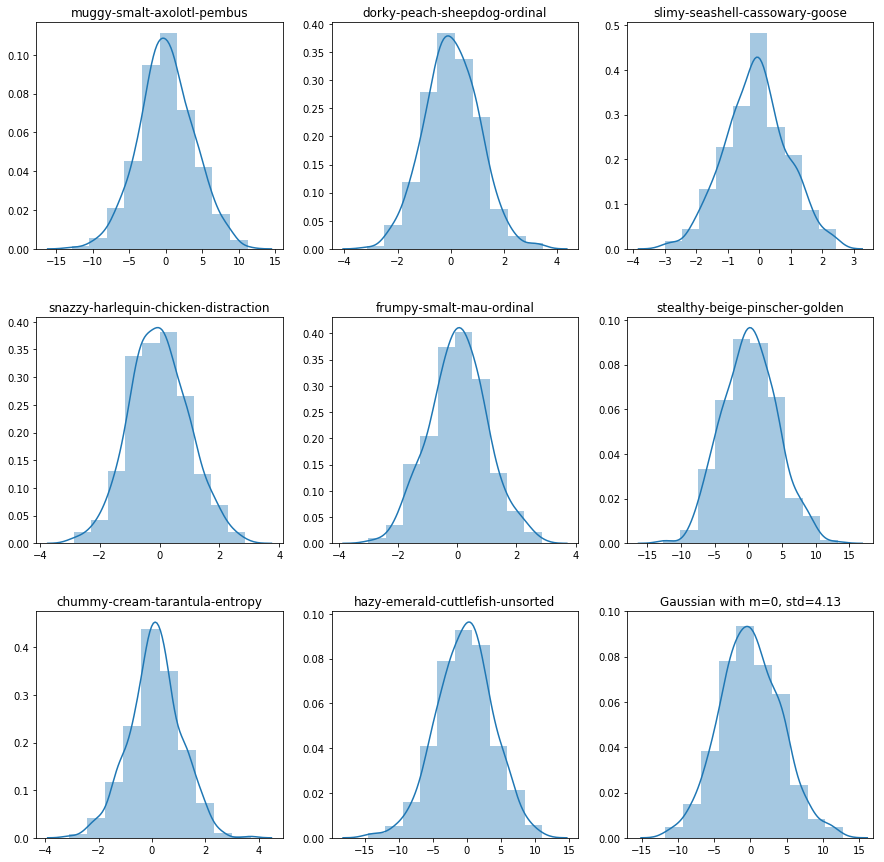

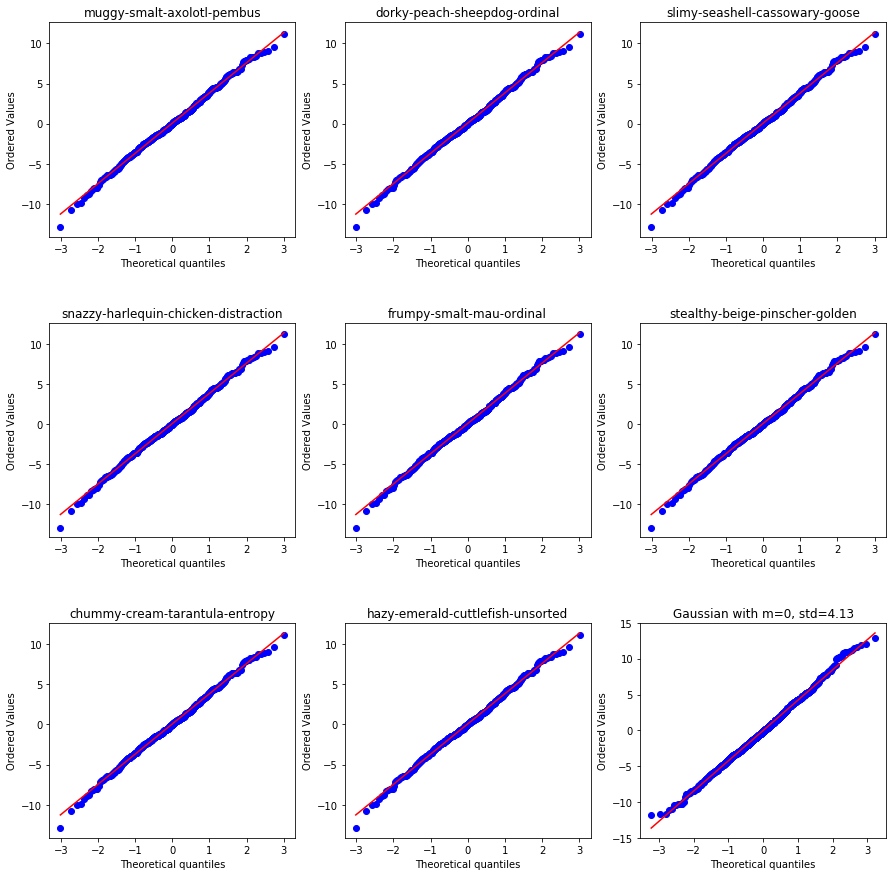

In [9]:
train0 = train.df[train.df['wheezy-copper-turtle-magic']==0 ]

# PLOT FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    #plt.hist(train0.iloc[:,i+1],bins=10)
    sns.distplot(train0.iloc[:,i+1],bins=10)
    plt.title(train.df.columns[i+1] )
    plt.xlabel('')
    
# PLOT GAUSSIAN FOR COMPARISON
plt.subplot(3,3,9)
std0 = round(np.std(train0.iloc[:,8]),2)
data0 = np.random.normal(0,std0,2*len(train0))
sns.distplot(data0,bins=10)
plt.xlim((-17,17))
plt.ylim((0,0.1))
plt.title("Gaussian with m=0, std="+str(std0))
    
plt.subplots_adjust(hspace=0.3)
plt.show()

# NORMALITY PLOTS FOR FIRST 8 VARIABLES
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3,i+1)
    stats.probplot(train0.iloc[:,1], plot=plt)
    plt.title(train.df.columns[i+1] )
    
# NORMALITY PLOT FOR GAUSSIAN
plt.subplot(3,3,9)
stats.probplot(data0, plot=plt)   
plt.title("Gaussian with m=0, std="+str(std0))

plt.subplots_adjust(hspace=0.4)
plt.show()

This discover hints us that it is not a bad idea to split the data set into values of identical *wheezy-copper-turtle-magic*, and train models for each of them. Let's figure out what kinds of values we get with this variable:

In [10]:
sorted(train.df['wheezy-copper-turtle-magic'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


There are 512 values, and they are all integer. Let's proceed with this dataset splitting idea. But first, we will prepare our data to start working:

In [11]:
train.strat_train_test_split(attrib='target', test_size=0.2)
train.get_labels(label_name='target')

train._train.drop("id", axis=1, inplace=True)
train._test.drop("id", axis=1, inplace=True)

train.set_attrib_types(cat_attribs=None)

pipeline = train.set_pipeline()

train_prepared = pipeline.fit_transform(train._train)
test_prepared = pipeline.transform(train._test)
train_labels = train._labelstrain
test_labels = train._labelstest

Now we carry on with the model fitting. Again, I'll be stealing from https://www.kaggle.com/cdeotte/support-vector-machine-0-925, as the proposed solution was great:

In [12]:
# LOAD LIBRARIES
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# INITIALIZE VARIABLES
oof = np.zeros(len(train.df))
preds = np.zeros(len(test.df))
attribs = [c for c in train.df.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

# BUILD 512 SEPARATE NON-LINEAR MODELS
for i in range(512):
    
    if i % 100 == 0:
        print(f'Entering model {i}')
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train.df[train.df['wheezy-copper-turtle-magic']==i]
    test2 = test.df[test.df['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[attribs])
    train3 = sel.transform(train2[attribs])
    test3 = sel.transform(test2[attribs])
        
    # STRATIFIED K FOLD (Using splits=25 scores 0.002 better but is slower)
    skf = StratifiedKFold(n_splits=11, random_state=42)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL WITH SUPPORT VECTOR MACHINE
        clf = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        
# PRINT VALIDATION CV AUC
auc = roc_auc_score(train.df['target'],oof)
print('CV score =',round(auc,5))


Entering model 0
Entering model 100
Entering model 200
Entering model 300
Entering model 400
Entering model 500
CV score = 0.92619


Great precision. We can now get back to this idea of Gaussian distributions. Are those variables independent? Let's see the correlation matrix of the original data set:

In [1]:
plt.figure(figsize=(80, 40))
sns.heatmap(cbar=False, annot=True, data=train.df.corr(), cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

NameError: name 'plt' is not defined

There variables have no correlation with each other, and they are all normally distributed for constant *wheezy-copper-turtle-magic*. We could try a Naive Bayes model to see what we can get:

In [36]:
print('Validation AUC =',roc_auc_score(train_labels, train_predictions))

Validation AUC = 0.525464782446748


This is an awful score. So it seems like the bell-shaped curves are not really Gaussian. Let's check some of these variables:

Let's check the correlation matrix for every variable:

In [20]:
from sklearn.naive_bayes import GaussianNB

# INITIALIZE VARIABLES
oof = np.zeros(len(train.df))
preds = np.zeros(len(test.df))
attribs = [c for c in train.df.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

# BUILD 512 SEPARATE NON-LINEAR MODELS
for i in range(512):
    
    if i % 100 == 0:
        print(f'Entering model {i}')
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train.df[train.df['wheezy-copper-turtle-magic']==i]
    test2 = test.df[test.df['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[attribs])
    train3 = sel.transform(train2[attribs])
    test3 = sel.transform(test2[attribs])
        
    # STRATIFIED K FOLD (Using splits=25 scores 0.002 better but is slower)
    skf = StratifiedKFold(n_splits=25, random_state=42)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL WITH SUPPORT VECTOR MACHINE
        clf = GaussianNB(priors=[0.5, 0.5])
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
        
# PRINT VALIDATION CV AUC
auc = roc_auc_score(train.df['target'],oof)
print('CV score =',round(auc,5))

Entering model 0
Entering model 100
Entering model 200
Entering model 300
Entering model 400
Entering model 500
CV score = 0.7969


It turns out that the results were not that great.

In [1]:
from sklearn import metrics, preprocessing

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) #hide warnings
from keras.layers import Dense, Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras import callbacks
from keras import backend as K
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler

import warnings
warnings.filterwarnings("ignore")

# CUSTOM METRICS
def fallback_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except:
        return 0.5

def auc(y_true, y_pred):
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

# ONE-HOT-ENCODE THE MAGIC FEATURE
len_train = train.shape[0]
test['target'] = -1
data = pd.concat([train, test])
data = pd.concat([data, pd.get_dummies(data['wheezy-copper-turtle-magic'])], axis=1, sort=False)

train = data[:len_train]
test = data[len_train:]

# PREPARE DATA AND STANDARDIZE
y = train.target
ids = train.id.values
train = train.drop(['id', 'target'], axis=1)
test_ids = test.id.values
test = test[train.columns]

all_auc_NN = []
oof_preds_NN = np.zeros((len(train)))
test_preds_NN = np.zeros((len(test)))

scl = preprocessing.StandardScaler()
scl.fit(pd.concat([train, test]))
train = scl.transform(train)
test = scl.transform(test)

NFOLDS = 15
RANDOM_STATE = 42

gc.collect()
# STRATIFIED K FOLD
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    #print("Current Fold: {}".format(fold_))
    trn_x, trn_y = train[trn_, :], y.iloc[trn_]
    val_x, val_y = train[val_, :], y.iloc[val_]

    # BUILD MODEL
    inp = Input(shape=(trn_x.shape[1],))
    x = Dense(2000, activation="relu")(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(1000, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(500, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)
    clf = Model(inputs=inp, outputs=out)
    clf.compile(loss='binary_crossentropy', optimizer="adam", metrics=[auc])
    
    # CALLBACKS
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10,
                verbose=0, mode='max', baseline=None, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                patience=3, min_lr=1e-6, mode='max', verbose=0)

    # TRAIN
    clf.fit(trn_x, trn_y, validation_data=(val_x, val_y), callbacks=[es, rlr], epochs=100, 
                batch_size=1024, verbose=0)
    
    # PREDICT TEST
    test_fold_preds = clf.predict(test)
    test_preds_NN += test_fold_preds.ravel() / NFOLDS
    
    # PREDICT OOF
    val_preds = clf.predict(val_x)
    oof_preds_NN[val_] = val_preds.ravel()
    
    # RECORD AUC
    val_auc = round( metrics.roc_auc_score(val_y, val_preds),5 )
    all_auc_NN.append(val_auc)
    print('Fold',fold_,'has AUC =',val_auc)
    
    K.clear_session()
    gc.collect()



C:\Users\barro\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'train' is not defined

In [40]:
print('Training Validation AUC =',roc_auc_score(train_labels, train_prediction))
print('Testing Validation AUC =',roc_auc_score(test_labels, test_prediction))

Training Validation AUC = 0.8174411327969617
Testing Validation AUC = 0.5403867388346655


There is some serious overfitting going on. Let's see how it goes when restarting the training:

In [41]:
print('Continue training')

gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=100,
                init_model=clf,
                learning_rates=lambda iter: 0.1 * (0.99 ** iter),
                valid_sets=lgb_eval)


Continue training
[101]	valid_0's binary_error: 0.470522
[102]	valid_0's binary_error: 0.470446
[103]	valid_0's binary_error: 0.470446
[104]	valid_0's binary_error: 0.47056
[105]	valid_0's binary_error: 0.469511
[106]	valid_0's binary_error: 0.469931
[107]	valid_0's binary_error: 0.46892
[108]	valid_0's binary_error: 0.468443
[109]	valid_0's binary_error: 0.468214
[110]	valid_0's binary_error: 0.469549
[111]	valid_0's binary_error: 0.469339
[112]	valid_0's binary_error: 0.468557
[113]	valid_0's binary_error: 0.468615
[114]	valid_0's binary_error: 0.46871
[115]	valid_0's binary_error: 0.468863
[116]	valid_0's binary_error: 0.468462
[117]	valid_0's binary_error: 0.469092
[118]	valid_0's binary_error: 0.468386
[119]	valid_0's binary_error: 0.467795
[120]	valid_0's binary_error: 0.467566
[121]	valid_0's binary_error: 0.468271
[122]	valid_0's binary_error: 0.46871
[123]	valid_0's binary_error: 0.4681
[124]	valid_0's binary_error: 0.468424
[125]	valid_0's binary_error: 0.467795
[126]	valid_0

In [42]:
train_prediction = gbm.predict(train_prepared)
test_prediction = gbm.predict(test_prepared)

print('Training Validation AUC =',roc_auc_score(train_labels, train_prediction))
print('Testing Validation AUC =',roc_auc_score(test_labels, test_prediction))

Training Validation AUC = 0.9127275797816008
Testing Validation AUC = 0.5520039294884741


Again, too much overfitting. Let's deal with simpler trees to see how far we can get:

In [44]:
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 5,
    "num_leaves" : 40,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 150,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 42,
    "verbosity" : 1,
    "seed": 42}

features = [feat for feat in train.df.columns if feat not in ['id', 'target']]

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lgbm(num_folds, params, stratified=False, debug=False, seed=42):
    
    test_prediction = np.zeros(len(train.df))
    predictions = np.zeros(len(test.df))
    #getVal = np.zeros(len(train.df))
    feature_importance_df = pd.DataFrame()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=False, random_state=seed)
    else:
        folds = KFold(n_splits=num_folds, shuffle=False, random_state=seed)

    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train.df.values, train.df.target.values),1):
        train_x, train_y = train.df.iloc[train_idx][features], train.df.target.iloc[train_idx]
        valid_x, valid_y = train.df.iloc[valid_idx][features], train.df.target[valid_idx]

        lgb_train = lgbm.Dataset(train_x, label=train_y)
        lgb_eval = lgbm.Dataset(valid_x, label=valid_y)
        
        gbm = lgbm.train(params, lgb_train,
                         valid_sets=[lgb_train,lgb_eval],
                         valid_names=['train', 'eval'],
                         num_boost_round=10000, verbose_eval=5000,
                         early_stopping_rounds = 2500) #,
                         #lambda iter: 0.051 + 0.05 * (np.cos(3*np.pi/5000*iter)))
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = gbm.feature_importance()
        fold_importance_df["fold"] = n_fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        #getVal[valid_idx]+= gbm.predict(train.df.iloc[valid_idx][features], 
        #                                num_iteration=gbm.best_iteration) / folds.n_splits
        
        test_prediction[valid_idx] = gbm.predict(train.df.iloc[valid_idx][features], num_iteration=gbm.best_iteration)

        print(f'{n_fold}o. fold Validation AUC ={roc_auc_score(train.df.target[valid_idx], test_prediction[valid_idx])}\n')

        predictions += gbm.predict(test.df[features], num_iteration=gbm.best_iteration) / folds.n_splits
    
    print("CV score: {:<8.5f}".format(roc_auc_score(train.df.target, test_prediction)))
    
    cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.show()
    
    return predictions

In [45]:
predictions = kfold_lgbm(num_folds=4, params=params, stratified=True)

Training until validation scores don't improve for 2500 rounds.
[5000]	train's auc: 0.778931	eval's auc: 0.535877
[10000]	train's auc: 0.848725	eval's auc: 0.540465
Did not meet early stopping. Best iteration is:
[10000]	train's auc: 0.848725	eval's auc: 0.540465
1o. fold Validation AUC =0.5404646560100184

Training until validation scores don't improve for 2500 rounds.
[5000]	train's auc: 0.786412	eval's auc: 0.543181
[10000]	train's auc: 0.85506	eval's auc: 0.545319
Did not meet early stopping. Best iteration is:
[10000]	train's auc: 0.85506	eval's auc: 0.545319
2o. fold Validation AUC =0.5453191983483914

Training until validation scores don't improve for 2500 rounds.


KeyboardInterrupt: 

In [47]:
test_prediction[valid_idx] = gbm.predict(train.df.iloc[valid_idx][features], num_iteration=gbm.best_iteration)

NameError: name 'gbm' is not defined

In [46]:
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": test.df.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission_barrozo.csv')

Saving the Submission File


In [53]:
len(train.df.target[train.df.target < 0.5])

179902

In [50]:
predictions

array([0.08914779, 0.19640424, 0.15669553, ..., 0.00577443, 0.09492827,
       0.06452294])